## Intro

The paper by Burak et. al demonstrates how the grid cell firing can be, with respect to different velocity inputs, generated by continuous attractor models.

[Burak, Yoram, and Ila R. Fiete. "Accurate path integration in continuous attractor network models of grid cells." PLoS Comput Biol 5.2 (2009): e1000291.](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000291)

For further reading, please have a look at:

[Moser, Edvard I., May-Britt Moser, and Yasser Roudi. "Network mechanisms of grid cells." Phil. Trans. R. Soc. B 369.1635 (2014): 20120511.](http://rstb.royalsocietypublishing.org/content/369/1635/20120511.short)

[Couey, Jonathan J., et al. "Recurrent inhibitory circuitry as a mechanism for grid formation." Nature neuroscience 16.3 (2013): 318-324.](http://www.nature.com/neuro/journal/v16/n3/abs/nn.3310.html)

As a start you should read the paper and familiarize yourself with the model.
Next we provided a coding framework (by Gwendolyn English), in which you can explore certain aspects of the model.
If you have questions, please contact: marksm@ethz.ch

## Setup

To access this repository please clone it with git, i.e.:
```
git clone https://github.com/damaggu/grid_cell_exercise_public.git
```

Please set up a clean python environment and install packages from the requriements.txt . If you are using pip please do so, the following way:

```
pip install virtualenv
virtualenv grid_cells --no-site-packages
source grid_cells/bin/activate
pip install -r requirements.txt

```

Now you should be all set up and ready for running the file.

For one of the tasks, you will initialize the network with some precomputed weights. These you need to download and put in this repository folder as well.

[Initial weights for Torus](http://goo.gl/TE8A0d)

## Task 1

First we look at the case of a non periodic continous attractor model. Trying to get the following code running for that case, you will notice that there is a piece of code missing (indicated). It's the recurrent connections of the network, which you will have to implement with brian notation. To do so you can familiarize yourself with the synapses part of brian (https://brian2.readthedocs.io/en/stable/resources/tutorials/2-intro-to-brian-synapses.html). Once done, you can integrate the recurrent weights from the Burak et. al paper in the code. The specific formulation of the recurrent connections can be found as equations (2) & (3) in the methods section. The values of a, gamma, beta, and lambda are already provided; if you adjust these values, please note an author error (gamma should equal 1.1, not 1.05 as written). 

Now we can run a simulation. To do so, please reduce the size of the network to 64 by 64 and run the simulation. Note that adjusting the size of the network will alter the effect of the wrapper function in the aperiodic network configuration. You can adjust the wrapper function values to see how varying the suppression of input at the boundaries effects the network population behavior. Save the resulting animation.

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr 20 11:23:53 2017
@author: gwendolynenglish
Model is based upon Grid Cell network proposed in 'Accurate Path Integration in Continuous Attractor
Network Models of Grid Cells' by Yoram Burak & Ila Fiete, 2009.
Parameters in this script are assigned & named as in the Methods section of the paper.
The larger size of the network makes it more robust against drift, however much slower for simulations.
One second of real-time requires approximately 800 seconds of simulation-time on a MacBookPro 2.7 GHz Intel Core i5
"""
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from brian2 import *
import numpy as np
import time
import csv
import pandas as pd

start_scope()
set_device('cpp_standalone')

#==============================================================================
# VARIABLE NETWORK CONDITIONS
#==============================================================================

#Set initialization variable to 0 for a non-initialized network
#Set initialization variable to 1 for a already initialized netowork
initialization = 1

#Set periodicity variable to 0 for an aperiodic network
#Set periodicity variable to 1 for a periodic network
# NOTE! For a periodic network, initialization must equal 1 :ie, already initialized
periodicity = 1

#==============================================================================
# NETWORK PARAMETERS
#==============================================================================

#Set size of network
rows, cols = 128,128        #total network size = 16,384

#Set parameters of neurons in network
tau = 10 * ms               #neuronal time constant

#Set values relevant to wrapper function, see paper for more details
ao = 4
R = 64
deltar = 64
alpha = 0.10315

#Set values relevant to synaptic connectivity, see paper for more details
a = 1
l = 2
lambdanet = 13*13
beta = 3 / lambdanet
gamma = 1.1 * beta

#Set simulation runtime & time step of integration
runtime = 1 * second
sim_dt = 0.5 * ms



#==============================================================================
# GRID CELL NEURONS
# Create Grid Cell neuron group and equations that govern the activity of cells.
#==============================================================================

#Define neuronal dynamics equations & parameters of each neuron
eqs = '''
ds/dt = -s/tau + clip((stot + B + I),0,(stot + B + I))/tau : 1
stot : 1
B = wrapper * (1 + alpha * (xdir * xmotionarray(t) + ydir * ymotionarray(t))) : 1
x : 1
y : 1
xdir : 1
ydir : 1
wrapper : 1
I : 1
'''

GridCells = NeuronGroup(rows*cols, model = eqs, method = 'linear')

#==============================================================================
# NETWORK INPUT
# Create velocity input for the network, broken down into x- & y-components, that
# represents the trajectory of the agent. During initialization, velocity is set
# to 0. After inialized pattern formation, the network receives velocity input
# in m/s.
#==============================================================================

if initialization == 0:
    GridCells.run_regularly('''I = ((rand()**.3)*.2)*.6''', dt = 50 * ms)
    xmotionarray = TimedArray([0], dt = 1000*ms)
    ymotionarray = TimedArray([0], dt = 1000*ms)

if initialization == 1:
    I = 0
    xmotionarray = TimedArray([0.20, 0.16, 0.59, 1.0, .23, -.29, -.90, .10, 1.1, -.19], dt = 100*ms)
    ymotionarray = TimedArray([0, 0.12, 0.81, .05, -.42, -.81, .19, .90, .43, -.26], dt = 100*ms)

#==============================================================================
# PARAMETER VALUES
# Call functions that assign a x- & y- location to each grid cell, a x- & y-
# direction preference to each grid cell, and a wrapper value to each grid cell.
# Wrapper values gate the strength of the input to the network at the
# boudaries so as to avoid pattern deformation.
#==============================================================================

#Functions that define x & y locations of neurons within the grid field.
def xcoord(rows):
    xarray = np.hstack((np.arange(-(rows/2),0, 1), np.arange(1,(rows/2)+1,1)))
    x = np.tile(xarray,rows)
    return x

def ycoord(rows):
    yarray = np.hstack((np.arange(-(rows/2),0, 1), np.arange(1,(rows/2)+1,1)))
    y = []
    for i in yarray:
        y = np.hstack((y, np.tile(i,rows)))
    return y

#Functions that define x & y components of preferred input directionality
#of neurons within the grid field
def pref_dir_x(rows):
    xdir_list = []
    for i in range(rows):
        if np.mod(i, 2) == 0:
            for j in range(int(rows/2)):
                xdir_list.append(-1)
                xdir_list.append(0)
        else:
            for j in range(int(rows/2)):
                xdir_list.append(0)
                xdir_list.append(1)
    return(xdir_list)

def pref_dir_y(rows):
    ydir_list = []
    for i in range(rows):
        if np.mod(i, 2) == 0:
            for j in range(int(rows/2)):
                ydir_list.append(0)
                ydir_list.append(-1)
        else:
            for j in range(int(rows/2)):
                ydir_list.append(1)
                ydir_list.append(0)
    return(ydir_list)

#Function that creates wrapper function over 2D grid cell network.
def wrapper(rows, R, deltar, ao, x, y):
    wrap = []
    for i in range(rows*rows):
        wrap.append(exp(-ao*(((sqrt(x[i]**2+y[i]**2)-R+deltar)/deltar)**2)))
    return wrap

#Create values of locations & preferred input directionality and
#assign them as to neurons with the GridCell NeuronGroup
locations = {'x': xcoord(rows),
             'y': ycoord(rows)}

#Call above functions and set states of motion orientation preferences.
preferred_direction = {'xdir' : pref_dir_x(rows),
                       'ydir' : pref_dir_y(rows)}

GridCells.set_states(locations)
GridCells.set_states(preferred_direction)

#If an aperiodic network is selected, apply wrapper function to suppress activity of neurons at
#the network boundaries
if periodicity == 0:
    wrapper_values = {'wrapper' : wrapper(rows, R, deltar, ao, xcoord(rows), ycoord(rows))}
    GridCells.set_states(wrapper_values)

#If an initialized network is selected, apply pre-determined values for the synaptic activations of each neuron
if initialization == 1:
    init_values = pd.read_csv('InitializationValuesHighPass.csv', header=None, skiprows =[0], dtype = float64)
    init_values = np.asarray(init_values)
    init_values = np.insert(init_values, 0, 0.007891481)
    initialization = {'s' : init_values}
    GridCells.set_states(initialization)

#==============================================================================
# RECURRENT SYNAPSES
# Create all to all recurrent activity within the Grid Cell field and generate
# synaptic weights according to neuronal distance
#==============================================================================
if periodicity == 1:
    torusweights = pd.read_csv('TorusWeights.csv', header=None, skiprows =[], dtype = float64)
    torusweights = np.asmatrix(torusweights)
    torusweights = torusweights.flatten()

#Generate synapses between grid cells.
#Use summed variable to pass the synaptic activation between neurons at every time step.
RecSyn = Synapses(GridCells, GridCells, '''w : 1
                            stot_post = w * s_pre : 1 (summed)''')

#Connect all grid cells to one another.
RecSyn.connect()

#Apply weights configured to either a periodic or aperiodic network
#For the twisted-torus periodic configuration, load predetermined values
if periodicity == 1: 
    
    RecSyn.w = torusweights
if periodicity == 0: 
    
    # --- Your code goes here----

    
    
    
#==============================================================================
# RUN & MONITOR SIMULATION
#==============================================================================
#Create monitor of synaptic activation of all grid cells.
M = StateMonitor(GridCells, ('s'), record = True)
defaultclock.dt = sim_dt
run(runtime, report = 'text')
all_s = M.s  #matrix that contains the synaptic activation of all grid cells at all times

#==============================================================================
# VISUALIZE SIMULATION
#==============================================================================
# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=100, metadata=dict(artist='Me'), bitrate= -1)

#Function that saves an animated heatmap of the synaptic activation levels over time.
def synact_ani(matrix, rows):
    fig_anim = plt.figure()
    heat = []
    plt.title("Synaptic Activation over Time")
    plt.xlabel("Planar representation of spatially organized grid cells")
    plt.xlim(1,rows)
    plt.ylim(1,rows)

    for add in np.arange(np.shape(matrix)[1]):
        slice = matrix[:,add]
        sliceplot = slice.reshape((rows,rows))
        heat.append((plt.pcolormesh(np.arange(1, rows + 1, 1),np.arange(1, rows + 1, 1),sliceplot, shading='gouraud'),))

    heat_ani = animation.ArtistAnimation(fig_anim, heat, interval = 50, repeat_delay = 3000, blit = True)
    heat_ani.save('synaptic_animation.mp4', writer = writer)

synact_ani(all_s,rows)

## Task 2

Now run the periodic case for a bigger network (i.e. 128 x 128) and save the resulting animation. Describe how they differ and why.

## Task 3


Now we want to generate a plot, that would be observed during an actual experiment. That is, the response of a single neurons along an arbitrary path through a given enviroment.

For this you need first to generate a 2D environment and a path(i.e. arbitrary path in a circular environment, as depicted). Verify this by plotting the environment and path.

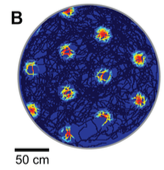

In [19]:
from IPython.display import display, Image
display(Image(data='./path.png'))

In [15]:
# ---- Your code goes here


Afterwards feed the trajectory into the network and project the response of a single cell onto the path plot. Your trajectory should be decomposed into x- and y- components of motion at the resolution of the integration time step (as provided, dt = 0.5) and provided as 'TimedArray's to the network. As this network is not spiking, you can identify the activity of single units by their 'synaptic activation' level, s. During the simulation, the synaptic activation level of all neurons is monitored in the 'StateMonitor'. Read the Brian2 documents to determine how to access the activation level of a particular neuron. Select a single neuron near the center to the attractor field (ie, 128 * 128 / 2 = 8,192), as this area of the network is not affected by the wrapper function. You will need to threshold the synaptic activation values to identify 'spikes'; try a threshold of s~0.28. Once you know the spike times (ie - threshold exceeding) of your neuron of interest, mark the corresponding location on your trajectory map. Is it comparable to the one shown above?

You should note that the activity of the network will drift over time, as it accumlulates error in integrating self-motion cues. As a result, you should limit the simulation time of this portion to no more than 3 minutes of motion. 

In [16]:
# ---- Your code goes here